In [1]:
import json
import matplotlib.pyplot as plt
from datetime import datetime
from collections import defaultdict
import os
import pandas as pd
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns



In [2]:
directories = os.listdir()
data_path = [dir for dir in directories if dir.startswith("data")][0]


In [3]:
def extract_all_features(folder_path):
    files = [f for f in os.listdir(folder_path) if f.endswith('.json')]
    #print(f"Found {len(files)} JSON files in {folder_path}.")
    records = []
    for file in files:
        with open(os.path.join(folder_path, file), 'r') as f:
            json_file = json.load(f)
            
            repo_name = next(iter(json_file))  # Get the first key as repository name
            #print(f"Processing file: {file} for repository: {repo_name}")
            list_of_commits = next(iter(json_file.values()))
            #agregated_results = 
            for commit in list_of_commits:
                #print(f"Processing commit {list_of_commits.index(commit)+1} at date {commit['Date']}")
                row = {"Date": commit['Date'], 
                       "Repository": repo_name}
                
                
                results_per_version = commit['ResultsPerVersion']
                for version in results_per_version:
                    version_nr = version['Version']
                    values = version['Values']
                    for key in values.keys():
                        row[key] = values[key]
                        if key not in features_:
                            features_.append(key)
                    #total_usage = sum(values.values())
                    
                    #row[version['Version']] = total_usage
                    #print(f"Total usage in version {version_nr} is {total_usage}.")
                
                records.append(row)
                
    return records


# versions_ = [ "7.1", "7.2", "7.3", "8", "9", "10", "11", "12"]
features_ =[]
df = extract_all_features(data_path)
df = pd.DataFrame(df)

df_binary = extract_all_features(data_path)
df_binary = pd.DataFrame(df)


df.to_csv("dataframe_language_features.csv", index=False)
# print(df.head(10))
df.to_csv("Test.csv", index=False)
df_binary.columns = df_binary.columns.astype(str).str.strip()
df_binary[features_] = (df_binary[features_]>0).astype(int)  # Convert to binary presence/absence
print(df_binary.head(10))

         Date Repository  async Main  Default expressions  \
0  20-03-2020    1Remote           0                    0   
1  28-03-2020    1Remote           0                    0   
2  12-04-2020    1Remote           0                    1   
3  20-04-2020    1Remote           0                    1   
4  04-05-2020    1Remote           0                    1   
5  07-05-2020    1Remote           0                    1   
6  14-05-2020    1Remote           0                    1   
7  20-05-2020    1Remote           0                    1   
8  15-06-2020    1Remote           0                    1   
9  01-07-2020    1Remote           0                    1   

   Inffered tuple element names  Pattern matching with generics  \
0                             0                               0   
1                             0                               0   
2                             0                               0   
3                             0                             

   YearMonth  RepoCount
0    2019-01         59
1    2019-02         54
2    2019-03         56
3    2019-04         67
4    2019-05         52
..       ...        ...
72   2025-01         57
73   2025-02         57
74   2025-03         53
75   2025-04         56
76   2025-05         51

[77 rows x 2 columns]


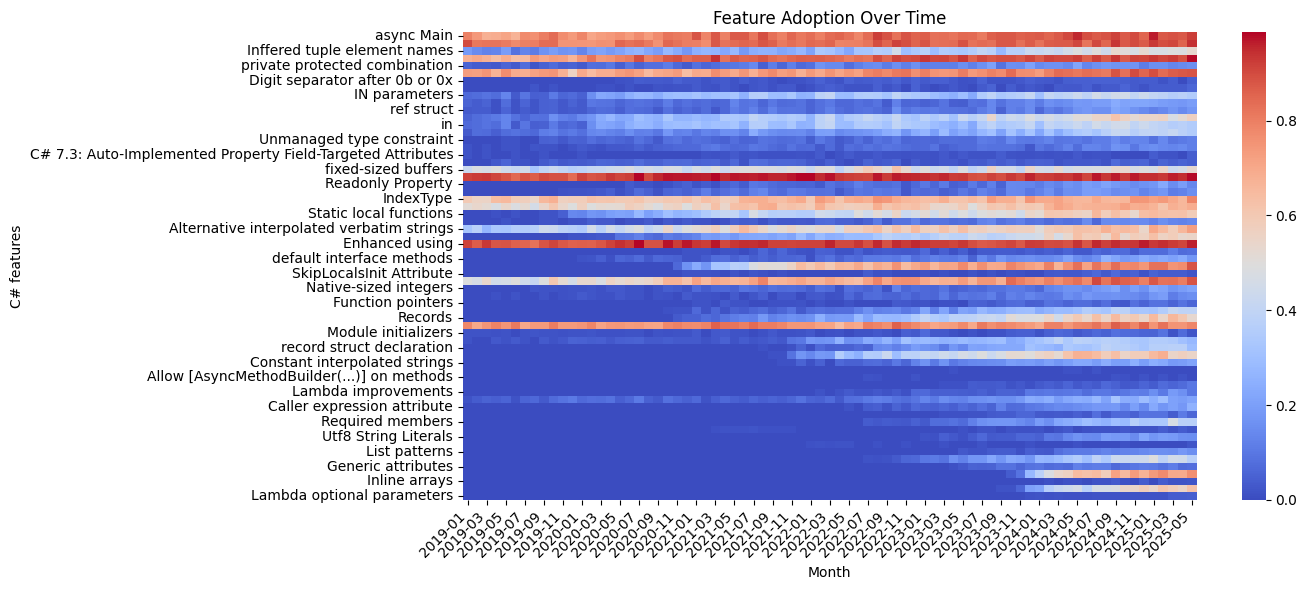

In [ ]:


df_binary["Date"] = pd.to_datetime(df_binary["Date"], dayfirst=True)
df_binary["YearMonth"] = df_binary["Date"].dt.to_period("M")

df_monthly = df_binary.sort_values(by="Date").groupby(["Repository", "YearMonth"]).tail(1).reset_index(drop=True)


df_monthly = df_monthly.sort_values(by=["Repository","Date"]).reset_index(drop=True)

df_monthly["Date"]= pd.to_datetime(df_monthly["Date"], dayfirst=True) #Convert date to proper datetime

df_monthly["Padding"] = 0 #Add the padding as 0 to existent columns, so when I add the new columns they will be aligned

df_monthly = df_monthly.set_index(["Repository","YearMonth"])

all_months = pd.period_range(start = df_monthly.index.get_level_values("YearMonth").min(),
                             end = df_monthly.index.get_level_values("YearMonth").max(),
                             freq='M')

repos = df_monthly.index.get_level_values("Repository").unique()

full_index = pd.MultiIndex.from_product([repos, all_months], names=["Repository", "YearMonth"])
df_monthly = df_monthly.reindex(full_index)
df_monthly["Padding"] = df_monthly["Padding"].fillna(1)  # Fill NaN values with 0

df_monthly[features_] = df_monthly[features_].fillna(0)  # Fill NaN values with 0 for versions

df_monthly = df_monthly.reset_index().sort_values(by=["Repository", "YearMonth"]).reset_index(drop=True)

df_monthly.to_csv("monthly_results.csv", index=True)
df_monthly = df_monthly[df_monthly["YearMonth"] >= pd.Period("2019-01", freq="M")]

monthly_repo_counts = (
    df_monthly[df_monthly["Padding"] == 0]
    .groupby("YearMonth")["Repository"]
    .nunique()
    .reset_index(name="RepoCount")
)
monthly_repo_counts.to_csv("monthly_repo_counts.csv", index=False)
print(monthly_repo_counts)


real_data = df_monthly[df_monthly["Padding"] == 0]

heatmap_data = (
    real_data.groupby("YearMonth")[features_]
    .mean()
    .T
)


In [5]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import pandas as pd

# Dictionary to store monthly similarity matrices
monthly_similarity_matrices = {}

# Get the list of months
months = df_monthly["YearMonth"].unique()

for month in months:
    monthly_df = df_monthly[
        (df_monthly["YearMonth"] == month) & (df_monthly["Padding"] == 0)
    ]

    if len(monthly_df) < 2:
        continue  # Skip months with fewer than 2 repos

    repo_names = monthly_df["Repository"].values
    feature_matrix = monthly_df[features_].values

    # Compute cosine similarity
    similarity = cosine_similarity(feature_matrix)

    # Store as DataFrame
    sim_df = pd.DataFrame(similarity, index=repo_names, columns=repo_names)
    monthly_similarity_matrices[month] = sim_df


In [6]:
# Get all unique repos across all months
all_repos = df_monthly["Repository"].unique()
avg_similarity_matrix = pd.DataFrame(0.0, index=all_repos, columns=all_repos)
pair_counts = pd.DataFrame(0, index=all_repos, columns=all_repos)

for sim_df in monthly_similarity_matrices.values():
    for r1 in sim_df.index:
        for r2 in sim_df.columns:
            avg_similarity_matrix.loc[r1, r2] += sim_df.loc[r1, r2]
            pair_counts.loc[r1, r2] += 1

# Avoid division by zero
nonzero_mask = pair_counts != 0
avg_similarity_matrix[nonzero_mask] /= pair_counts[nonzero_mask]


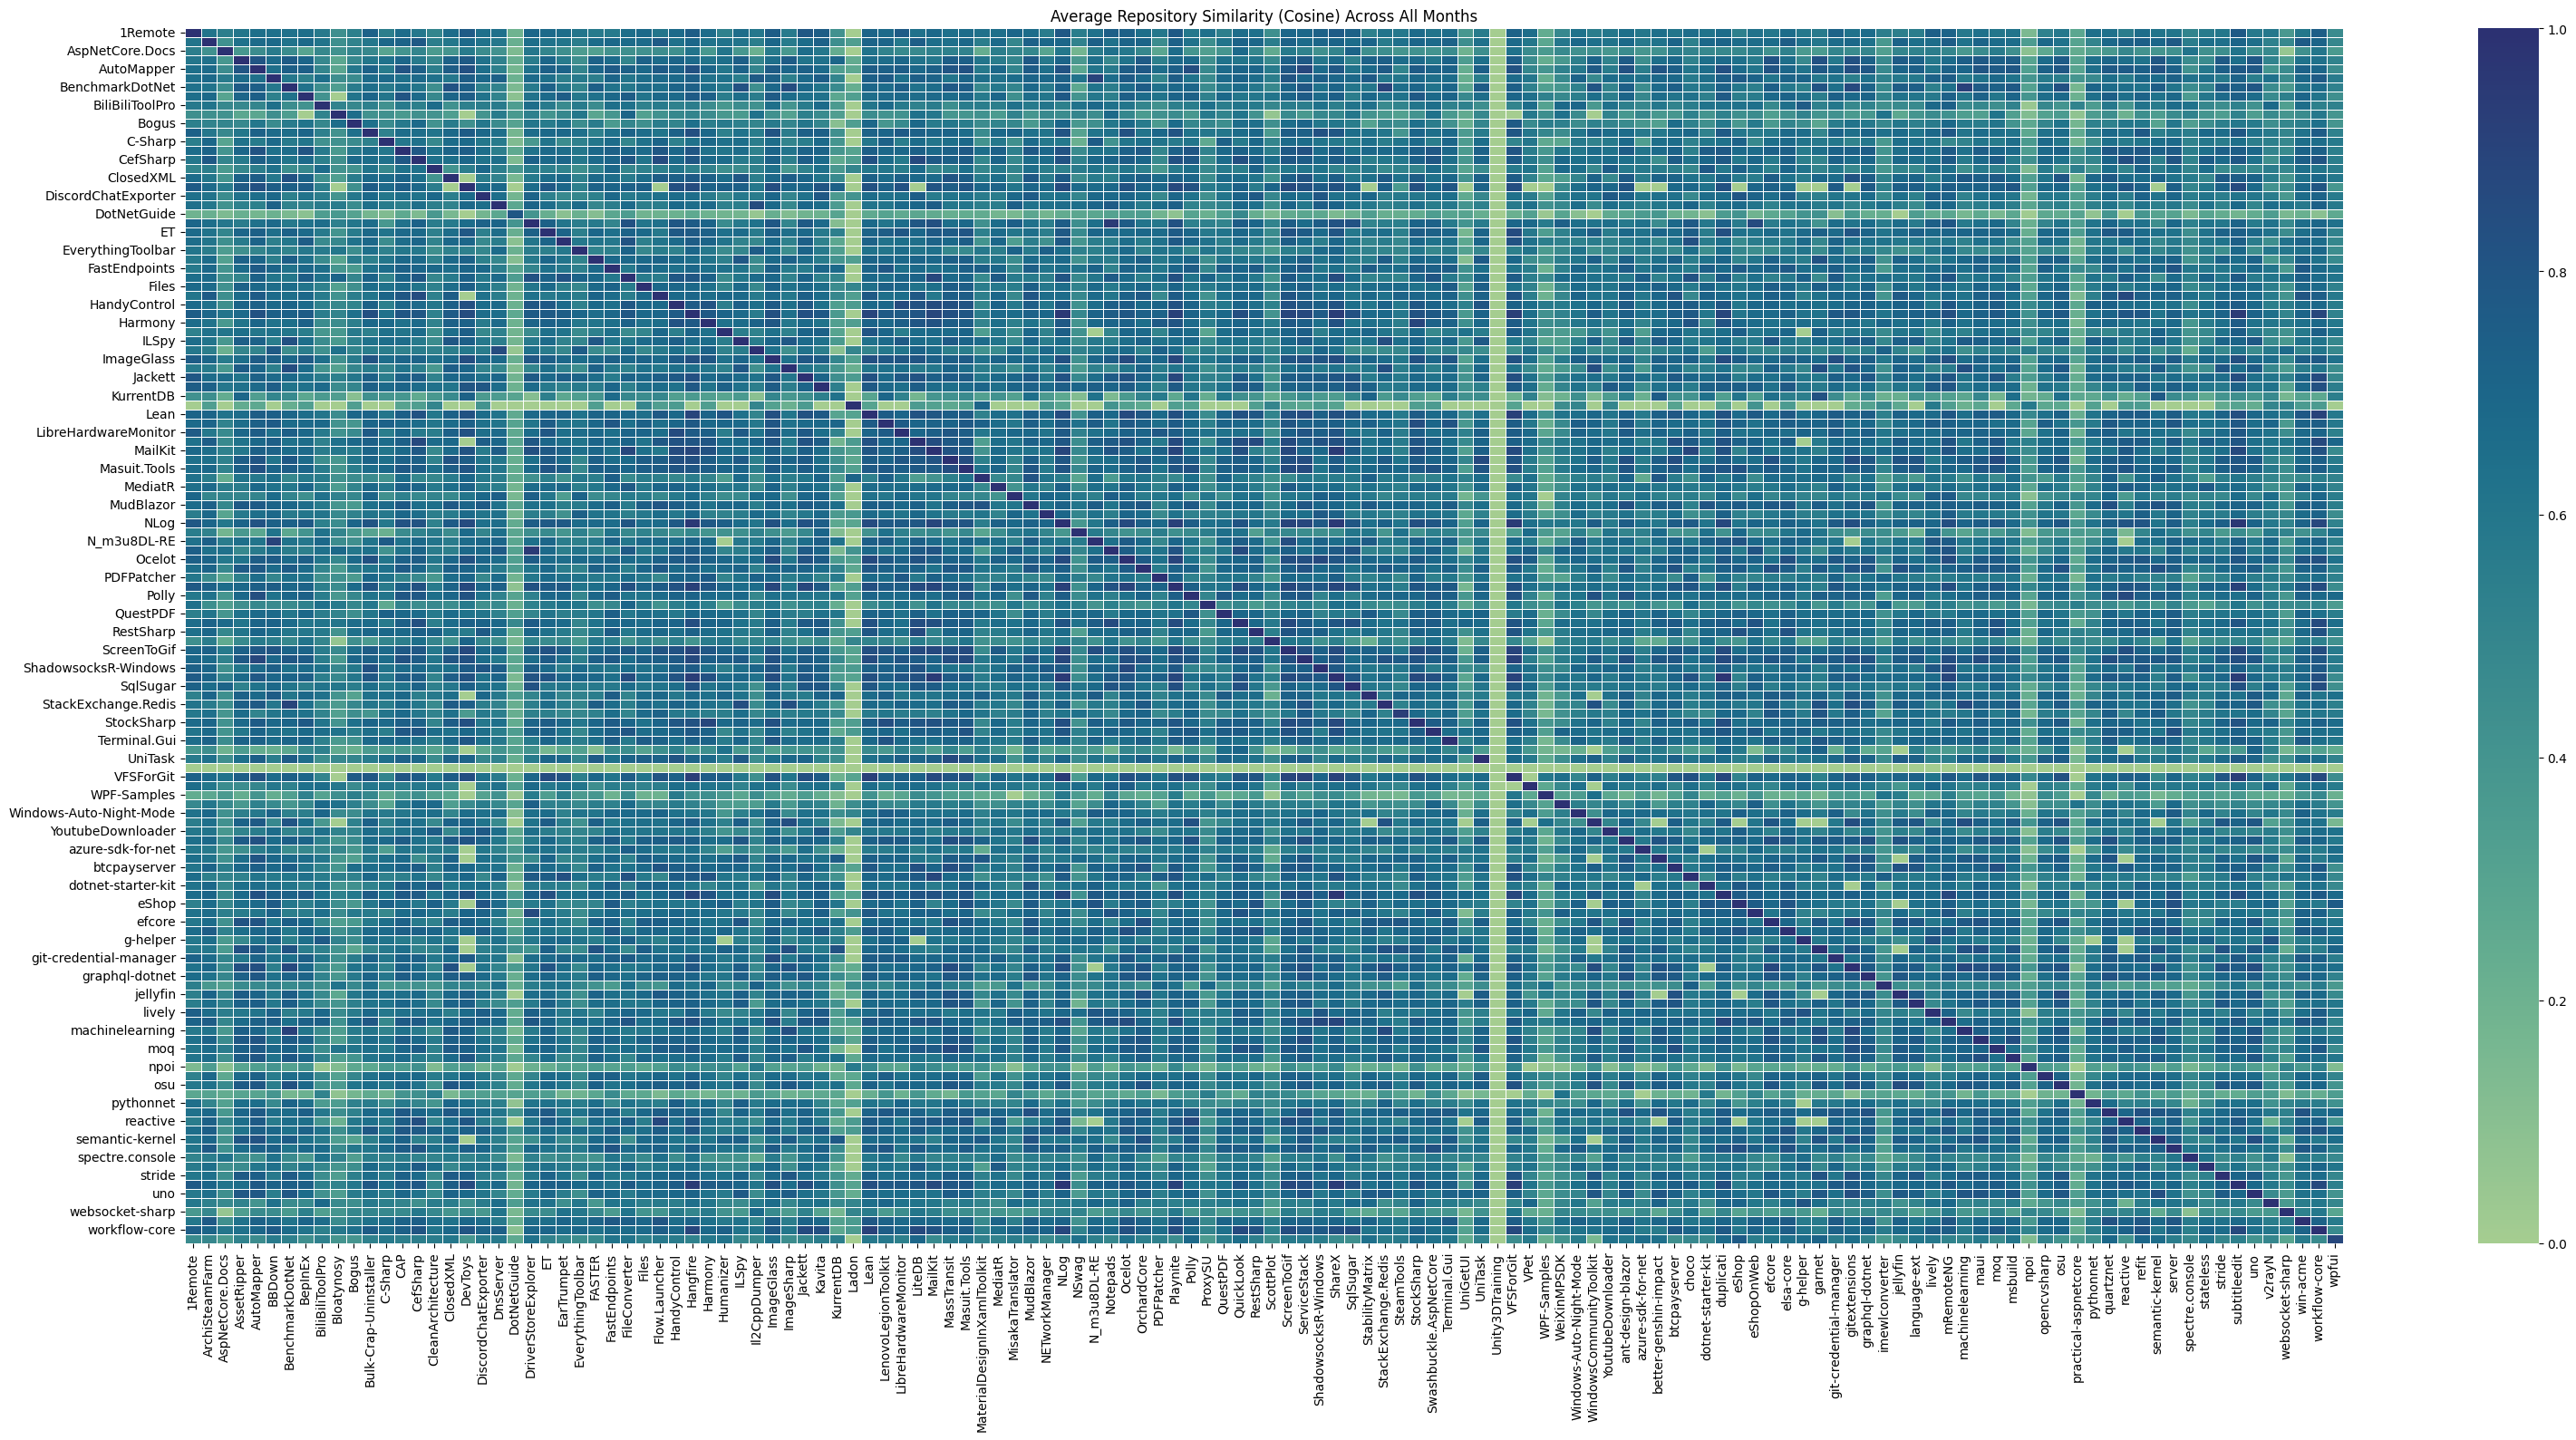

In [7]:
plt.figure(figsize=(32, 16))
sns.heatmap(avg_similarity_matrix, cmap="crest", linewidths=0.5)
plt.title("Average Repository Similarity (Cosine) Across All Months")
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


c:\RP\ResultAnalyzer\venv\Lib\site-packages\sklearn\metrics\pairwise.py:2463: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
c:\RP\ResultAnalyzer\venv\Lib\site-packages\sklearn\metrics\pairwise.py:2463: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
c:\RP\ResultAnalyzer\venv\Lib\site-packages\sklearn\metrics\pairwise.py:2463: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
c:\RP\ResultAnalyzer\venv\Lib\site-packages\sklearn\metrics\pairwise.py:2463: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
c:\RP\ResultAnalyzer\venv\Lib\site-packages\sklearn\metrics\pairwise.py:2463: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
c:\RP\ResultAnalyzer\venv\Lib\

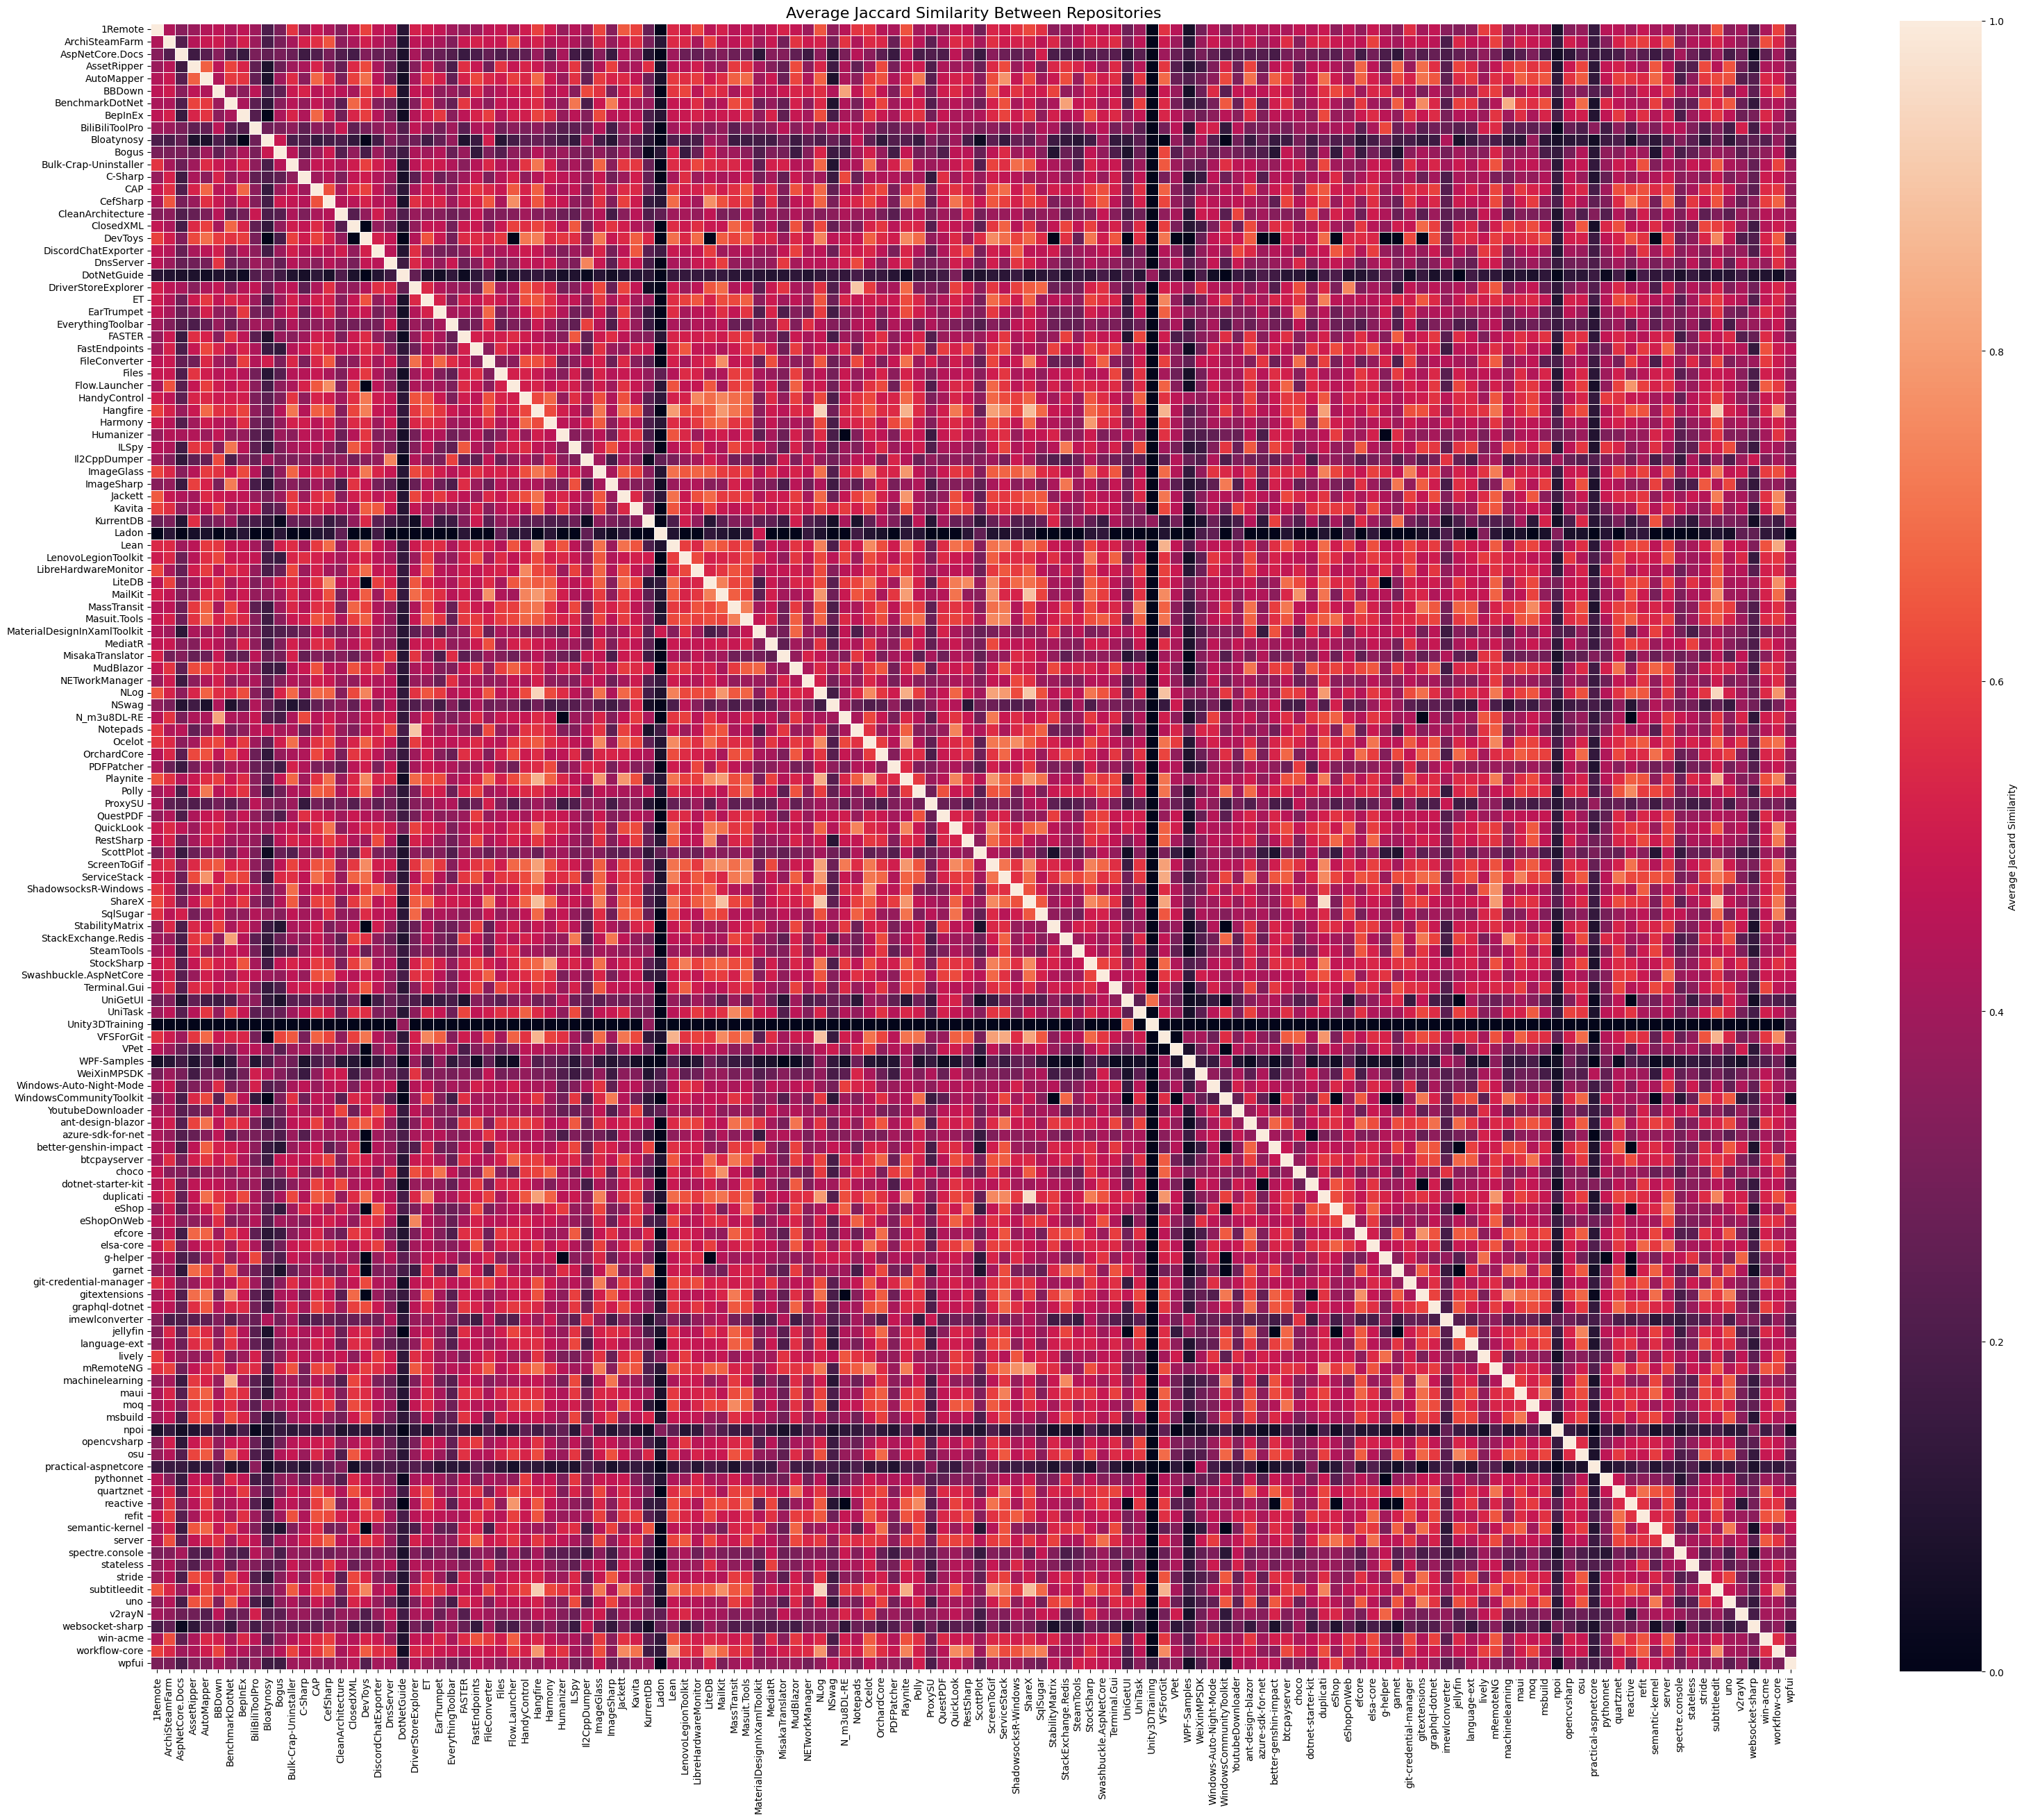

In [ ]:
from sklearn.metrics import pairwise_distances
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Prepare data
real_data = df_monthly[df_monthly["Padding"] == 0]
months = real_data["YearMonth"].unique()

# Step 2: Compute monthly Jaccard similarity matrices
monthly_similarity_matrices = {}

for month in months:
    monthly_df = real_data[real_data["YearMonth"] == month]

    if len(monthly_df) < 2:
        continue  # Skip months with too few repos

    repo_names = monthly_df["Repository"].values
    feature_matrix = monthly_df[features_].values

    # Compute Jaccard similarity (1 - Jaccard distance)
    jaccard_dist = pairwise_distances(feature_matrix, metric="jaccard")
    jaccard_sim = 1 - jaccard_dist

    sim_df = pd.DataFrame(jaccard_sim, index=repo_names, columns=repo_names)
    monthly_similarity_matrices[month] = sim_df

# Step 3: Compute average similarity matrix
all_repos = df_monthly["Repository"].unique()
avg_similarity_matrix = pd.DataFrame(0.0, index=all_repos, columns=all_repos)
pair_counts = pd.DataFrame(0, index=all_repos, columns=all_repos)

for sim_df in monthly_similarity_matrices.values():
    for r1 in sim_df.index:
        for r2 in sim_df.columns:
            avg_similarity_matrix.loc[r1, r2] += sim_df.loc[r1, r2]
            pair_counts.loc[r1, r2] += 1

# Avoid division by zero
nonzero = pair_counts != 0
avg_similarity_matrix[nonzero] /= pair_counts[nonzero]

# Optional: Fill NaNs with 0 if no overlap
avg_similarity_matrix = avg_similarity_matrix.fillna(0)
# Remove rows and columns where all similarities are zero
non_zero_repos = avg_similarity_matrix[(avg_similarity_matrix != 0).any(axis=1)].index
avg_similarity_matrix = avg_similarity_matrix.loc[non_zero_repos, non_zero_repos]
sorted_repos = avg_similarity_matrix.sort_values(ascending=False).index

# Reorder rows and columns
avg_similarity_matrix = avg_similarity_matrix.loc[sorted_repos, sorted_repos]
# Step 4: Visualize
plt.figure(figsize=(32, 32))
sns.heatmap(
    avg_similarity_matrix,
    cmap="rocket",
    linewidths=0.5,
    linecolor='white',
    cbar_kws={"shrink": 0.75, "label": "Average Jaccard Similarity"},
    square=True,
    xticklabels=True,
    yticklabels=True
)
plt.title("Average Jaccard Similarity Between Repositories", fontsize=16)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()
